### General Setup

**NOTE:** It is expected that the Notebooks are run **inside VS Code** as it allows the pathing for `task_configs` to work. If it is run outside a VS Code instance, please adjust the following line:

```py
notebook_name = "/".join(
    IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[-5:]
)
```

The cell down below has the following configuration attributes, which might need adjustment depending on changes of the experimental design

- `metrics`: Inside this dictionary the keys represent the actual names of the metric, as they are displayed on `comet`, while the values are simply just given the according type that will be fetched from online.
  
- `parameters`: The parameters describe general experimental setup information, which were passed as arguments upon execution
  
- `task_names`: The task names represent the data sets upon which the Outlier Detection Strategies were trained on
  
- `task_configs`: The task configs represent the path to the configuration files of the `task names`.

In [ ]:
import comet_ml as comet
import IPython
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from typing import Dict, List, Any, DefaultDict, Optional
from collections.abc import Callable
import numpy as np
import textwrap
from collections import defaultdict
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())
API = comet.API()

metrics = {
    "AutoFilter_Chen_Like_HTL Count": float,
    "AutoFilter_Chen_Like_avg_duration": float,
    "AutoFilter_Chen_Like_medF1 (No HTL)": float,
    "AutoFilter_Chen_Like_medF1 (With HTL)": float,
    "AutoFilter_Chen_Like_avgF1 (random replacement)": float,
    "AutoFilter_Chen_Like_avgF1 (No HTL)": float,
    "AutoFilter_Chen_Like_avgF1 (With HTL)": float,
    "AutoFilter_Chen_Like_medF1 (random replacement)": float,
    "HDBScanFilter_HTL Count": float,
    "HDBScanFilter_avg_duration": float,
    "HDBScanFilter_medF1 (No HTL)": float,
    "HDBScanFilter_medF1 (With HTL)": float,
    "HDBScanFilter_medF1 (random replacement)": float,
    "HDBScanFilter_avgF1 (No HTL)": float,
    "HDBScanFilter_avgF1 (With HTL)": float,
    "HDBScanFilter_avgF1 (random replacement)": float,
    "IsolationForestFilter_HTL Count": float,
    "IsolationForestFilter_avg_duration": float,
    "IsolationForestFilter_avgF1 (No HTL)": float,
    "IsolationForestFilter_avgF1 (With HTL)": float,
    "IsolationForestFilter_avgF1 (random replacement)": float,
    "IsolationForestFilter_medF1 (No HTL)": float,
    "IsolationForestFilter_medF1 (With HTL)": float,
    "IsolationForestFilter_medF1 (random replacement)": float,
    "LocalOutlierFactorFilter_HTL Count": float,
    "LocalOutlierFactorFilter_avg_duration": float,
    "LocalOutlierFactorFilter_avgF1 (No HTL)": float,
    "LocalOutlierFactorFilter_avgF1 (With HTL)": float,
    "LocalOutlierFactorFilter_avgF1 (random replacement)": float,
    "LocalOutlierFactorFilter_medF1 (No HTL)": float,
    "LocalOutlierFactorFilter_medF1 (With HTL)": float,
    "LocalOutlierFactorFilter_medF1 (random replacement)": float,
    "LoserFilter_Plain_HTL Count": float,
    "LoserFilter_Plain_avg_duration": float,
    "LoserFilter_Plain_avgF1 (No HTL)": float,
    "LoserFilter_Plain_avgF1 (With HTL)": float,
    "LoserFilter_Plain_avgF1 (random replacement)": float,
    "LoserFilter_Plain_medF1 (No HTL)": float,
    "LoserFilter_Plain_medF1 (With HTL)": float,
    "LoserFilter_Plain_medF1 (random replacement)": float,
    "SingleStepEntropy_SimplePseudo_HTL Count": float,
    "SingleStepEntropy_SimplePseudo_avg_duration": float,
    "SingleStepEntropy_SimplePseudo_avgF1 (No HTL)": float,
    "SingleStepEntropy_SimplePseudo_avgF1 (With HTL)": float,
    "SingleStepEntropy_SimplePseudo_avgF1 (random replacement)": float,
    "SingleStepEntropy_SimplePseudo_medF1 (No HTL)": float,
    "SingleStepEntropy_SimplePseudo_medF1 (With HTL)": float,
    "SingleStepEntropy_SimplePseudo_medF1 (random replacement)": float,
}
parameters = {
    "strategy_name": str,
    "filter_strategy_name": str,
    "seed": int,
    "task": str,
}

task_names = [
    "ag-news",
    "dbpedia",
    "fnc1",
    "imdb",
    "qnli",
    "rotten-tomatoes",
    "sst2",
    "trec",
    "wiki-talk",
]

version = "x"
task_names = [version + t for t in task_names]

# This gets the location of the Notebook, needs VSCode to be executed correctly
notebook_name = "/".join(
    IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[-5:]
)

BASE_PATH = Path(notebook_name).parent
CONFIGS_PATH = BASE_PATH.parent / "Configs" / "Tasks"

task_configs = {
    "xAG News": CONFIGS_PATH / "ag_news.json",
    "xDBPedia": CONFIGS_PATH / "dbpedia.json",
    "xFNC1": CONFIGS_PATH / "fnc_one.json",
    "xIMDB": CONFIGS_PATH / "imdb.json",
    "xQNLI": CONFIGS_PATH / "qnli.json",
    "xRotten Tomatoes": CONFIGS_PATH / "rotten_tomatoes.json",
    "xSST2": CONFIGS_PATH / "sst2.json",
    "xTREC": CONFIGS_PATH / "trec.json",
    "xWiki Talk": CONFIGS_PATH / "wiki_talk.json",
}

seed_count = 20  # How many different seeds do we expect?

COMET_WORKSPACE = "final-experiment-all-filters"
filter_names = [
    "HDBScanFilter LocalOutlierFactorFilter IsolationForestFilter SimpleDSM SemanticAE SimpleSS"
]

filter_names_final_experiment = [
    "HDBScanFilter", "LocalOutlierFactorFilter", "IsolationForestFilter", "SimpleDSM", "SemanticAE", "SimpleSS"
    ]

In [7]:
def extract_used_metrics(experiment_metrics: List[Dict[str, Any]]) -> List[Dict]:
    """
    Extract a list of unique metrics from the given experiment metrics that are also present in the `metrics` list.

    Args:
        experiment_metrics (List[Dict[str, Any]]): A list of dictionaries where each dictionary
            represents a metric with various attributes, including "metricName".

    Returns:
        List[Dict]: A list of unique metric dictionaries where "metricName" exists in the global `metrics` list.
    """
    metrics_used: List[Dict] = []
    for metric in experiment_metrics:
        if metric["metricName"] in metrics:
            metrics_used.append(metric)
    return metrics_used


def extract_paremeter_value(
    parameters_used: List[Dict[str, Any]], parameter_name: str
) -> str | float:
    """
    Extracts the current value of a specified parameter from a list of parameters.

    Args:
        parameters_used (List[Dict[str, Any]]): A list of dictionaries containing parameter information.
        parameter_name (str): The name of the parameter to extract.

    Returns:
        str | float: The current value of the specified parameter.
    """
    parameters_dict = [
        entry for entry in parameters_used if entry.get("name") == parameter_name
    ]
    return parameters_dict[0]["valueCurrent"]


def load_experiment_data(
    experiment: comet.APIExperiment, final_experiment: Optional[bool] = False, filter_strategy: Optional[str] = ""
) -> DefaultDict[str, DefaultDict[str, DefaultDict[str, Dict[str, Any]]]]:
    """
    Loads and organizes experiment data, including metrics, parameters, and assets.

    Args:
        experiment (comet.APIExperiment): A Comet APIExperiment object containing experiment data.

    Returns:
        DefaultDict[str, DefaultDict[str, DefaultDict[str, Dict[str, Any]]]]: A nested dictionary with tasks, seeds, and experiment data.
    """

    experiment_parameters = experiment.get_parameters_summary()
    task = extract_paremeter_value(experiment_parameters, "task")
    seed = extract_paremeter_value(experiment_parameters, "seed")

    if final_experiment:
        filter_strategy = extract_paremeter_value(experiment_parameters, "filter_strategy_name")

    kwargs = {
        "task" : task,
        "seed" : seed,
        "filter_strategy" : filter_strategy
    }

    download_assets(experiment, **kwargs)



def download_assets(experiment:comet.APIExperiment, task: str, seed: str, filter_strategy: Optional[str] = "") -> Dict[str, np.ndarray]:
    """
    Downloads and saves the assets of an experiment, filtering out unnecessary files.

    Args:
        experiment (comet.APIExperiment): A Comet APIExperiment object containing the experiment data.
        task (str): The task name associated with the experiment.
        seed (str): The seed value associated with the experiment.

    Returns:
        Dict[str, np.ndarray]: A dictionary of downloaded assets, loaded as NumPy arrays.
    """
    assets = experiment.get_asset_list()
    filtered_assets = [
        asset
        for asset in assets
        if "durations" not in asset["fileName"]
        and not asset["fileName"].endswith(".py")
    ]

    asset_ids = []
    for asset in filtered_assets:
        asset_ids.append((asset["fileName"], asset["assetId"]))

    for file_name, idx in asset_ids:
        asset_data = experiment.get_asset(idx)
        if filter_strategy:
            asset_path = Path(f"./cache/assets/{COMET_WORKSPACE}/{task}/{seed}/{filter_strategy}_{file_name}")
        else:
            asset_path = Path(f"./cache/assets/{COMET_WORKSPACE}/{task}/{seed}/{file_name}")
        asset_path.parent.mkdir(parents=True, exist_ok=True)
        with open(asset_path, "wb") as f:
            f.write(asset_data)


def download_workspace_data(task_name: str, final_exp: Optional[bool] = False) -> None:
    """
    Loads experiment data for a specific project from the Comet workspace.

    Args:
        project_name (str): The name of the project to load data from.
    """
    experiments = API.get(workspace=COMET_WORKSPACE, project_name=task_name)
    for exp in experiments:
        load_experiment_data(exp, final_experiment=final_exp)


def main() -> None:
    for task_name in task_names:
        download_workspace_data(task_name)

def main_final_exp() -> None:
    for task_name in task_names:
        download_workspace_data(task_name, final_exp=True)


# main()
main_final_exp()

In [ ]:
def is_integer_directory(dir_path: Path) -> bool:
    """Check if the directory name is an integer."""
    return dir_path.name.isdigit()

def collect_asset_paths(ASSET_PATHS: Optional[Path] = Path("cache", "assets", COMET_WORKSPACE)) -> DefaultDict[str, List]:
    TASK_ASSET_MAP = defaultdict(list)
    for dir_path in ASSET_PATHS.glob('**/*'):
        if dir_path.is_dir() and is_integer_directory(dir_path):
            task_name = dir_path.parent.name
            if task_name != COMET_WORKSPACE:
                TASK_ASSET_MAP[task_name].append(dir_path)

    return TASK_ASSET_MAP

def check_for_every_strategy(ASSET_PATHS: Optional[Path] = Path("cache", "assets", COMET_WORKSPACE)):
    strategies_map = defaultdict(lambda: defaultdict(list))
    for path in ASSET_PATHS.glob('**/*'):
        if path.name.endswith("_f1s.npy"):
            strategy_name = path.name.replace("_f1s.npy", "")
            seed_name = path.parent.name
            task_name = path.parent.parent.name
            if task_name != COMET_WORKSPACE:
                strategies_map[task_name][seed_name].append(strategy_name)

    return strategies_map

def find_missing_seeds_count(task_asset_map: DefaultDict[str, List], final_experiment: Optional[bool] = False) -> DefaultDict[str, List]:
    seed_map = defaultdict(list)
    for task, asset_paths in task_asset_map.items():
        seeds = [int(path.name) for path in asset_paths]
        missing_seeds: List | None = np.setdiff1d(np.arange(42, 42 + seed_count), seeds).tolist()
        seed_map[task] = missing_seeds

    skipped_tasks = np.setdiff1d(list(task_configs.keys()), list(task_asset_map.keys())).tolist()
    for task in skipped_tasks:
        seed_map[task] = np.arange(42, 42 + seed_count).tolist()

    if final_experiment:
        missed_strategies = defaultdict(lambda: defaultdict(list))
        filter_strategies_length = len(filter_names_final_experiment)
        strategies_map = check_for_every_strategy()
        for task, seed_dict in strategies_map.items():
            for seed, strategies_list in seed_dict.items():
                if len(strategies_list) != filter_strategies_length:
                    missing_strategies = np.setdiff1d(filter_names_final_experiment, strategies_list)
                    missed_strategies[task][seed] = missing_strategies

    if missed_strategies:
        print("The following Strategies were skipped during experiments: ")
        for task, seed_dict2 in missed_strategies.items():
            for seed, strategies_list in seed_dict2.items():
                print(f"{task} - {seed}: {strategies_list}")

    return seed_map


TASK_ASSET_MAP = collect_asset_paths()
missing_seeds = find_missing_seeds_count(task_asset_map=TASK_ASSET_MAP, final_experiment=True)
print("\nMissed seeds during experiments")
missing_seeds

### (Optional) Find Missing Experimental Seeds

In [7]:
collected_data: List[pd.DataFrame] = []

def get_task_config(task: Path) -> Path:
    """Transform in the input `task` into a Path object.

    Args:
        task (Path): A Path object, containing the full Path to the config

    Returns:
        Path: A relative Path based on the `task_configs` dict based on the relative Path: `Configs/Task/`
    """
    return task.relative_to(task.parents[2])


def generate_missing_seeds_df(missing_seeds: DefaultDict[str, List]) -> None:
    for task_name, missed_seeds in missing_seeds.items():
        task = get_task_config(task_configs[task_name])
        if missed_seeds:
            df = pd.DataFrame(
            [
                {"seed": seed, "filter": filter_names[0], "task": task, "workspace": COMET_WORKSPACE}
                for seed in missed_seeds
            ]
            )
            collected_data.append(df)

    if collected_data:
        missing_experiments = pd.concat(collected_data)
        missing_experiments = missing_experiments[
            missing_experiments["filter"].isin(filter_names)
        ]
        missing_experiments.to_csv(f"missing_std_experiments_{COMET_WORKSPACE}.csv", mode="w+")
        missing_experiments


def main():
    TASK_ASSET_MAP = collect_asset_paths()
    missing_seeds = find_missing_seeds_count(task_asset_map=TASK_ASSET_MAP, final_experiment=True)
    generate_missing_seeds_df(missing_seeds)

main()

In [8]:
def find_intervals(seeds: list[int]) -> List[List[int]]:
    """Finds the largest contiguous intervals in a list of integers. It groups consecutive integers into a sublist.

    Args:
        seeds (list[int]): A list of integers to find (all and) the largest intervals from.

    Raises:
        ValueError: If the provided list for `seeds` is empty.

    Returns:
        List[List[int]]: A list of lists, where each inner list contains a contiguous interval of integers.

    Examples:
        >>> find_intervals([1, 2, 3, 5, 6, 7, 9])
        [[1, 2, 3], [5, 6, 7], [9]]

        >>> find_intervals([10, 11, 13, 14, 15, 16])
        [[10, 11], [13, 14, 15, 16]]
    """
    if not seeds:
        raise ValueError(
            f"The provided list for `seeds` ({seeds}) has: {len(seeds)} elements!"
        )
    intervals = []

    sub_interval = [seeds[0]]

    for index in range(1, len(seeds)):
        if seeds[index] == seeds[index - 1] + 1:
            sub_interval.append(seeds[index])
        else:
            # Add the completed interval to the result and start a new interval right after
            intervals.append(sub_interval)
            sub_interval = [seeds[index]]

    # Append the last interval, as it only gets added within the iteration, so the last one would be missing
    intervals.append(sub_interval)
    return intervals


def generate_task_scripts(
    intervals: List[List[int]], task_config: str, workspace: str
) -> None:
    for index, interval in enumerate(intervals):
        start = interval[0] - 42
        end = interval[-1] - 42

        # A task has the structure "Configs/Tasks/<task_name>.json" -> we want the <task_name>.json, then remove the ".json"
        task_name_cleaned = task_config.split("/")[-1].split(".")[0]
        # Common SLURM script header
        slurm_header = textwrap.dedent(
            f"""\
            #!/bin/bash
            #SBATCH --nodes=1              # request 1 node
            #SBATCH --cpus-per-task=6      # use 6 threads per task
            #SBATCH --gres=gpu:1           # use 1 GPU per node (i.e. use one GPU per task)
            #SBATCH --time=100:00:00       # run for 100 hours
            #SBATCH --mem=10G
            #SBATCH --account=p_ml_il
            #SBATCH --job-name={workspace}-{task_config}
            #SBATCH --output=./slurm-runs/{workspace}/{workspace}-{task_name_cleaned}-%a-%A-%j.out
            #SBATCH --exclude=i8003,i8007,i8008,i8009,i8011,i8014,i8021,i8023,i8027,i8032
        """
        )

        # Array setup if start and end differ
        array_directive = f"#SBATCH --array={start}-{end}\n" if start != end else ""

        # Command to calculate random seed
        seed_command = (
            f"random_seed=$((42 + ${{SLURM_ARRAY_TASK_ID}}))"
            if start != end
            else f"random_seed={interval[0]}"
        )

        # Common SLURM script body
        slurm_body = textwrap.dedent(
            f"""\
            {array_directive}
            module --force purge
            module load release/23.04 GCC/11.3.0 Python/3.10.4
            source /data/horse/ws/toma076c-outlier-detection/venv/bin/activate

            nvidia-smi
            hostname

            # Calculate the random seed within the SLURM script
            {seed_command}

            echo "Seed: ${{random_seed}}"

            srun python3 main.py \
                --task_config ./{task_config} \
                --experiment_config ./Configs/standard.json \
                --filter_strategy_name HDBScanFilter LocalOutlierFactorFilter IsolationForestFilter SimpleDSM SemanticAE SimpleSS \
                --comet_api_key {API.api_key} \
                --comet_workspace {workspace} \
                --random_seed ${{random_seed}}
        """
        )

        # Write the complete SLURM script
        with open(f"{workspace}-{task_name_cleaned}-{index}.sh", "w+") as rsh:
            rsh.write(slurm_header + slurm_body)


def collect_missing_experiment_seeds(missing_experiments: pd.DataFrame) -> None:
    unique_tasks = missing_experiments["task"].unique()
    for task in unique_tasks:
        # We only care for all the rows that match the current task, so we create a subset of the df
        task_df = missing_experiments.loc[missing_experiments["task"] == task]
        seeds = sorted(
            task_df["seed"].values
        )  # Sort the seeds, to assure the biggest intervals are found
        workspace = task_df["workspace"].iloc[0]
        task_intervals = find_intervals(seeds)
        generate_task_scripts(intervals=task_intervals, task_config=task, workspace=workspace)


missing_experiments = pd.read_csv(f"missing_std_experiments_{COMET_WORKSPACE}.csv")
x = collect_missing_experiment_seeds(missing_experiments=missing_experiments)

### Plot Filter vs No Filter & Filter vs Random

In [ ]:
filter_names_clean = {
    "LoserFilter_Plain": "Simple DSM",
    "AutoFilter_Chen_Like": "Semantic AE",
    "SingleStepEntropy_SimplePseudo": "Simple SS",
    "HDBScanFilter": "HDBScan",
    "IsolationForestFilter": "IsolationForest",
    "LocalOutlierFactorFilter": "LocalOutlierFactor",
}

def load_asset_data(workspace_data: DefaultDict[str, List[Path]]) -> Dict[str, pd.DataFrame]:

    asset_data = {}
    for task_name, asset_dirs in workspace_data.items():
        collected_assets = []
        for asset_dir in asset_dirs:
            asset_paths = asset_dir.glob("*")
            collected_dfs = []
            for asset_path in asset_paths:
                data = np.load(asset_path)
                if data.size == 0:
                    print(f"{asset_path} is empty")
                df = pd.DataFrame(data={asset_path.name[:-4]: [data]})
                if df.empty:
                    print(f"Careful! For '{task_name}', the '{asset_path}' file is empty.")
                else:
                    collected_dfs.append(df)

            collected_assets.append(pd.concat(collected_dfs, axis=1))

        asset_data[task_name] = pd.concat(collected_assets, axis=0, ignore_index=True)


    return asset_data


def clean_up_asset_name(asset_name: str) -> str:
    """
    This function removes the `_no_htl` and `_random` extension from the asset.
    For example: `AutoFilter_Chen_Like_no_htl` would be transformed into `AutoFilter_Chen_Like`.
    Args:
        asset_name (str): The name of the asset to be (potentially) changed, as some do not have the aforementioned suffixes

    Returns:
        str: The updated asset_name
    """
    if asset_name.endswith("_no_htl") or asset_name.endswith("_random"):
        asset_name = asset_name[:-7]

    cleaned_asset = filter_names_clean[asset_name]
    return cleaned_asset


def calculate_averages(
    asset_data: Dict[str, Dict[str, pd.DataFrame]]
) -> DefaultDict[str, DefaultDict[str, np.float64]]:

    summarised_data = defaultdict(lambda: defaultdict(dict))

    for task_name, asset_df in asset_data.items():
        for asset_name in asset_df.columns:
            arrays_for_col = asset_df[asset_name].values
            flattened_array = np.concatenate(arrays_for_col)
            if flattened_array.size == 0:
                print(f"Empty array found for: {asset_name} in {task_name}")
            else:
                mean = flattened_array.mean()
                summarised_data[task_name][asset_name] = mean

    return summarised_data


def prepare_data():
    workspace_data = collect_asset_paths()
    asset_data = load_asset_data(workspace_data=workspace_data)
    summarised_data = calculate_averages(asset_data)
    return summarised_data

def transform_into_percentual_difference(asset_df: pd.DataFrame) -> pd.DataFrame:
    for col in asset_df.columns:
        if col != "HTL":
            asset_df[col] = (asset_df[col] - asset_df["HTL"]).mul(100)

    return asset_df


def filter_no_htl(asset_name: str) -> bool:
    """
    This is a helper function for the `create_comparison_df()` function. It is used to compare `No HTL` with `HTL`, so the filter condition looks for assets that contain `_no_htl` in their name.

    Args:
        asset_name (str): The asset to check for.

    Returns:
        bool: Returns `True` if the asset ends with `_no_htl`, else defaults to `False`.
    """
    return asset_name.endswith("_no_htl")


def filter_random(asset_name: str) -> bool:
    """
    This is a helper function for the `create_comparison_df()` function. It is used to compare `Random (Filled Up)` with `HTL`, so the filter condition looks for assets that contain `_random` in their name.

    Args:
        asset_name (str): The asset to check for.

    Returns:
        bool: Returns `True` if the asset ends with `_random`, else defaults to `False`.
    """
    return asset_name.endswith("_random")


def create_comparison_df(
    data: DefaultDict[str, DefaultDict[str, np.float64]],
    filter_condition: Callable[[str], bool],
) -> pd.DataFrame:
    """
    Generates a comparison DataFrame by filtering asset names based on a given condition
    and transforming them into percentual differences.

    This function processes a nested dictionary structure where each task contains a dictionary
    of assets and their corresponding values. For each task, it filters the asset names according
    to the provided `filter_condition` function, cleans up asset names as needed, and collects
    assets ending with "HTL". The resulting DataFrame for each task is transformed into percentual
    differences and concatenated into a final DataFrame.

    Args:
        data (DefaultDict[str, DefaultDict[str, np.float64]]):
            A nested dictionary where the outer key is the task name, the inner dictionary contains
            asset names as keys and their values as floats.

        filter_condition (Callable[[str], bool]):
            A function that takes an asset name (string) and returns a boolean indicating whether
            the asset should be included in the comparison. The function is responsible for determining
            if an asset meets the filtering criteria.

    Returns:
        pd.DataFrame:
            A concatenated DataFrame containing percentual differences for the filtered assets
            across all tasks.
    """

    dfs: list[pd.DataFrame] = []
    for task_name, asset_dict in data.items():
        collected_assets = {}
        for asset_name, asset_value in asset_dict.items():
            if filter_condition(asset_name):
                cleaned_asset = clean_up_asset_name(asset_name)
                collected_assets[cleaned_asset] = asset_value
            elif asset_name.endswith("HTL"):
                collected_assets[asset_name] = asset_value

        asset_df = transform_into_percentual_difference(
            asset_df=pd.DataFrame(data=collected_assets, index=[task_name])
        )
        dfs.append(asset_df)

    merged_df = pd.concat(dfs)
    return merged_df


def main():
    summarised_data = prepare_data()
    data_filtered = create_comparison_df(summarised_data, filter_no_htl)
    data_unfiltered = create_comparison_df(summarised_data, filter_random)

    sns.set_theme()
    sns.xkcd_palette
    fig, axes = plt.subplots(1, 2, figsize=(17, 9))

    sns.heatmap(
        data=data_filtered[data_filtered.columns.difference(["HTL"])],                     # Overlap matrix as data
        annot=True,                    # Annotate cells with values
        fmt=".2f",                     # Format annotations to 2 decimal places
        annot_kws={"size": 8},         # Font size for annotations
        linewidths=0.5,                # Thin borders for each cell
        linecolor='grey',              # Grey borders to define the stairwell look
        cbar_kws={'shrink': 0.5},      # Shrink color bar for fitting
        square=True,                    # Square cells for a structured look
        ax=axes[0]
    )
    axes[0].set_title("Filtered vs Unfiltered")

    sns.heatmap(
    data=data_unfiltered[data_unfiltered.columns.difference(["HTL"])],                     # Overlap matrix as data
    annot=True,                    # Annotate cells with values
    fmt=".2f",                     # Format annotations to 2 decimal places
    annot_kws={"size": 8},         # Font size for annotations
    linewidths=0.5,                # Thin borders for each cell
    linecolor='grey',              # Grey borders to define the stairwell look
    cbar_kws={'shrink': 0.5},      # Shrink color bar for fitting
    square=True,                    # Square cells for a structured look
    ax=axes[1]
    )
    axes[1].set_title("Random(Filled Up) vs Unfiltered")

# main()



### Significance Test

In [ ]:
# 5.3 Significance Test from Paper

# HTL mit NO HTL Vergleich & Random mit NO HTL vergleichen <-- Random hinzufügen (einfach assets laden)
import deepsig
import pandas as pd
import logging

logging.basicConfig(
    filename='app.log',        # Log file name
    filemode='a',              # Append mode (use 'w' for overwrite)
    level=logging.DEBUG,       # Minimum log level to handle
    format='%(asctime)s - %(levelname)s - %(message)s' # Log message format
)

def helper_function(significance_test_data: Dict[str, pd.DataFrame], filter_condition: Callable[[str], bool]) -> Dict[str, Dict[str, np.ndarray]]:
    results = {}
    for task_name, asset_df in significance_test_data.items():
        collected_assets = {}
        for col in asset_df.columns:
            if filter_condition(col):
                cleaned_asset = clean_up_asset_name(col)
                flattened_array = np.concatenate(asset_df[col].values)
                if flattened_array.size == 0:
                    print(f"Empty array found for: {col} in {task_name}")
                else:
                    collected_assets[cleaned_asset] = flattened_array
            elif col.endswith("HTL"):
                collected_assets[col] = np.concatenate(asset_df[col].values)

        results[task_name] = collected_assets

    return results


def prepare_significance_test_data(filter_condition: Callable[[str], bool]) -> Dict[str, pd.DataFrame]:
    workspace_data = collect_asset_paths()
    asset_data = load_asset_data(workspace_data=workspace_data)

    return helper_function(asset_data, filter_condition)


def signifance_test(comparison_data: Dict[str, pd.DataFrame], file_name: str):
    results = []
    for task_name, assets_dict in comparison_data.items():
        task_aso = []
        htl_data = assets_dict["HTL"]
        for filter_strategy, data in assets_dict.items():
            if filter_strategy != "HTL":
                if (len(data) != seed_count * 30) or (len(htl_data) != seed_count * 30):
                    logging.error(f"Error! In {task_name} the filterstrategy '{filter_strategy}' has '{len(data)}' Data, and '{len(htl_data)}' HTL Data but expected were: '{seed_count * 30}'")


                better = deepsig.aso(data, htl_data, num_bootstrap_iterations=10000, num_jobs=8, seed=42)
                task_aso.append(better)

        assets_dict.pop("HTL", None)
        results.append(pd.DataFrame(data=[task_aso], columns=assets_dict.keys(), index=[f"{task_name}_{file_name}"]))

    df = pd.concat(results)
    df.to_csv(f"{COMET_WORKSPACE}_{file_name}.csv")

def no_htl_vs_htl():
    return prepare_significance_test_data(filter_no_htl)

def random_vs_htl():
    return prepare_significance_test_data(filter_random)

def main():
    # signifance_test(no_htl_vs_htl(), "no_htl_better")
    signifance_test(random_vs_htl(), "random_better")
    logging.debug("Done with random_better")


# main()


### Visualize Significance Test

In [ ]:
sns.set_theme()
sns.xkcd_palette
fig, axes = plt.subplots(1, 2, figsize=(17, 9))

no_htl = pd.read_csv("./outlier-detection_no_htl_better.csv")
no_htl.index = [updated_index.split("_")[0] for updated_index in list(no_htl.index)]
random_better = pd.read_csv("./outlier-detection_random_better.csv")
random_better.index = [updated_index.split("_")[0] for updated_index in list(random_better.index)]

sns.heatmap(
    data=no_htl,                     # Overlap matrix as data
    annot=True,                    # Annotate cells with values
    fmt=".2f",                     # Format annotations to 2 decimal places
    annot_kws={"size": 8},         # Font size for annotations
    linewidths=0.5,                # Thin borders for each cell
    linecolor='grey',              # Grey borders to define the stairwell look
    cbar_kws={'shrink': 0.5},      # Shrink color bar for fitting
    square=True,                    # Square cells for a structured look
    ax=axes[0]
)
axes[0].set_title("Significance Test No HTL vs HTL")
# "Here no HTL was set A and HTL was set B. Meaning that if the significance test < 0.25 then no HTL was statistically better than HTL.",

sns.heatmap(
data=random_better,                     # Overlap matrix as data
annot=True,                    # Annotate cells with values
fmt=".2f",                     # Format annotations to 2 decimal places
annot_kws={"size": 8},         # Font size for annotations
linewidths=0.5,                # Thin borders for each cell
linecolor='grey',              # Grey borders to define the stairwell look
cbar_kws={'shrink': 0.5},      # Shrink color bar for fitting
square=True,                    # Square cells for a structured look
ax=axes[1]
)
axes[1].set_title("Significance Test Random(Filled Up) vs HTL")



### Marked Samples Measurements

In [ ]:
from itertools import combinations

def collect_asset_paths(ASSET_PATHS: Optional[Path] = Path("cache", "assets", COMET_WORKSPACE)) -> DefaultDict[str, List]:
    TASK_ASSET_MAP = defaultdict(list)
    for path in ASSET_PATHS.glob('**/*'):
        if path.name.endswith("_Marked_Samples.npy"):
            task_name = path.parent.parent.name
            if task_name != COMET_WORKSPACE:
                TASK_ASSET_MAP[task_name].append(path)

    return TASK_ASSET_MAP

def load_asset_data(workspace_data: DefaultDict[str, List[Path]]) -> Dict[str, pd.DataFrame]:
    results = {}
    for task_name, assets in workspace_data.items():
        collected_dfs = defaultdict(list)

        for asset_path in assets:
            data = np.load(asset_path)
            if data.size == 0:
                print(f"{asset_path} is empty")

            filter_strategy_name = filter_names_clean[asset_path.name.replace("_Marked_Samples.npy", "")]
            collected_dfs[filter_strategy_name].append(data)


        results[task_name] = pd.DataFrame(collected_dfs)
    return results

def group_by_filter_strategy(paths: List[Path]) -> DefaultDict[str, List[Path]]:
    collected_dfs = defaultdict(list)
    for asset_path in paths:
        filter_strategy_name = filter_names_clean[asset_path.name.replace("_Marked_Samples.npy", "")]
        collected_dfs[filter_strategy_name].append(asset_path)

    return collected_dfs

def load_asset_data_for_coefficients(workspace_data: DefaultDict[str, List[Path]]) -> Dict[str, pd.DataFrame]:
    results = {}
    for task_name, assets in workspace_data.items():

        collected_dfs = group_by_filter_strategy(assets)

        tmp = []
        for strategy, paths in collected_dfs.items():
            seeds = []
            seed_data = []
            for path in sorted(paths):
                data = np.load(path)
                seed = int(path.parent.stem)

                seeds.append(seed)
                seed_data.append(data)

            df = pd.DataFrame(data={strategy : seed_data}, index=seeds)

            tmp.append(df)


        results[task_name] = pd.concat(tmp, axis=1)
    return results

def check_for_null(df: pd.DataFrame, strategy1: str, strategy2: str) -> bool:
    return pd.isnull(df.loc[strategy1, strategy2])

def update_coefficient_value(df: pd.DataFrame, strategy1: str, strategy2: str, coefficient_index: float):
        df.loc[strategy1, strategy2] = coefficient_index


def calculate_jaccard(x1: np.ndarray, x2: np.ndarray) -> float:
    intersection = np.intersect1d(x1, x2).size
    union = np.union1d(x1, x2).size
    return (intersection / union) if union > 0 else 0


def calculate_overlap(x1, x2):
    intersection = np.intersect1d(x1, x2).size
    min_set = min(x1.size, x2.size)
    return (intersection / min_set) if min_set > 0 else 0



def calculate_coefficient_matrix(asset_data: Dict[str, pd.DataFrame], coefficient: Callable[[np.ndarray, np.ndarray], float]) -> pd.DataFrame:

    total_seeds = np.array([42 + i for i in range(0, seed_count)])
    strategies = np.array(asset_data[next(iter(asset_data))].columns)
    strategy_pairs = list(combinations(strategies, 2))

    total_results = []
    for task_name, df in asset_data.items():
        df_index = np.array(df.index)
        # task_results = []
        diff = np.setdiff1d(total_seeds, df_index)
        if diff.size > 0:
            print(f"For the task '{task_name}' in '{COMET_WORKSPACE}' are incomplete seed values, namely: {diff}")

        for index in df_index:
            intermediate_results = pd.DataFrame(index=strategies, columns=strategies)
            for strategy1, strategy2 in strategy_pairs:
                coffiecient_index = coefficient(
                    df.loc[index, strategy1],
                    df.loc[index, strategy2]
                )

                update_coefficient_value(intermediate_results, strategy1, strategy2, coffiecient_index)
                update_coefficient_value(intermediate_results, strategy2, strategy1, coffiecient_index)

            np.fill_diagonal(intermediate_results.values, 1)
            total_results.append(intermediate_results)
        
        # total_results.append(sum(task_results) / len(task_results))

    overlap_matrix = sum(total_results) / len(total_results)
    overlap_matrix = overlap_matrix.astype(float)
    return overlap_matrix

def plot_data(data: pd.DataFrame, coefficient_name: str):
    # Set up the plot in stairwell style
    sns.set_theme(style="white")
    colors = sns.color_palette("YlGnBu", as_cmap=True)  # Stairwell-style color palette

    # Plot the heatmap
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    sns.heatmap(
        data=data,                     # Overlap matrix as data
        cmap=colors,                   # Use stairwell style color map
        annot=True,                    # Annotate cells with values
        fmt=".2f",                     # Format annotations to 2 decimal places
        annot_kws={"size": 8},         # Font size for annotations
        linewidths=0.5,                # Thin borders for each cell
        linecolor='grey',              # Grey borders to define the stairwell look
        cbar_kws={'shrink': 0.5},      # Shrink color bar for fitting
        square=True                    # Square cells for a structured look
    )

    for spine in ax.spines.values():
        spine.set_visible(True)   # Set spine visibility to True
        spine.set_linewidth(0.75)    # Adjust border width
        spine.set_color('grey')  # Set border color


    plt.tight_layout()
    ax.set_title(f"{coefficient_name} Coefficient Heatmap for Filter Strategies", fontsize=12, pad=10)
    plt.show()


def jaccard_coefficient(asset_data: Dict[str, pd.DataFrame]):
    overlap_matrix = calculate_coefficient_matrix(asset_data, calculate_jaccard)
    plot_data(overlap_matrix, "Jaccard")

def overlap_coefficient(asset_data: Dict[str, pd.DataFrame]):
    overlap_matrix = calculate_coefficient_matrix(asset_data, calculate_overlap)
    plot_data(overlap_matrix, "Overlap")


def average_marked_samples() -> None:
    workspace_data = collect_asset_paths()
    marked_samples = load_asset_data(workspace_data=workspace_data)

    dfs = []
    for task_name, df in marked_samples.items():
        collected_assets = {}
        for col in df.columns:
            avg_marked = np.concatenate(df[col].values).size / df[col].size
            collected_assets[col] = avg_marked

        asset_df = pd.DataFrame(data=collected_assets, index=[task_name])
        dfs.append(asset_df)

    merged_df = pd.concat(dfs)

    sns.set_theme()
    colors = sns.color_palette("YlGnBu", as_cmap=True)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    sns.heatmap(
        data=merged_df,
        cmap=colors,                   # Use stairwell style color map
        annot=True,                    # Annotate cells with values
        fmt=".2f",                     # Format annotations to 2 decimal places
        annot_kws={"size": 8},         # Font size for annotations
        linewidths=0.75,                # Thin borders for each cell
        linecolor='black',              # Grey borders to define the stairwell look
        cbar_kws={'shrink': 0.5},      # Shrink color bar for fitting
    )

    for spine in ax.spines.values():
        spine.set_visible(True)   # Set spine visibility to True
        spine.set_linewidth(0.75)    # Adjust border width
        spine.set_color('grey')  # Set border color

    # Adjust the layout to make boxes fit better
    plt.tight_layout()
    ax.set_title(f"Average Marked Samples for each Filter Strategy over {seed_count} seeds.", fontsize=12, pad=10)  # You can change the title, font size, and padding

    plt.show()



asset_paths = collect_asset_paths()
loaded_assets = load_asset_data_for_coefficients(asset_paths)
overlap_coefficient(loaded_assets)
jaccard_coefficient(loaded_assets)
average_marked_samples()

### Final Experiment Visualisation

/var/folders/dh/xcdm9tld6jbcmqr3hlpk5d_m0000gn/T/ipykernel_14093/982264190.py:92: UserWarning: The palette list has more values (20) than needed (4), which may not be intended.
  sns.boxplot(data=df_melted, x="Filter Strategy", y="F1-Scores", hue="Group", palette=custom_palette, showmeans=True, width=0.5, gap=0.5, meanprops={"marker":"d","markerfacecolor":"black", "markeredgecolor":"black"})


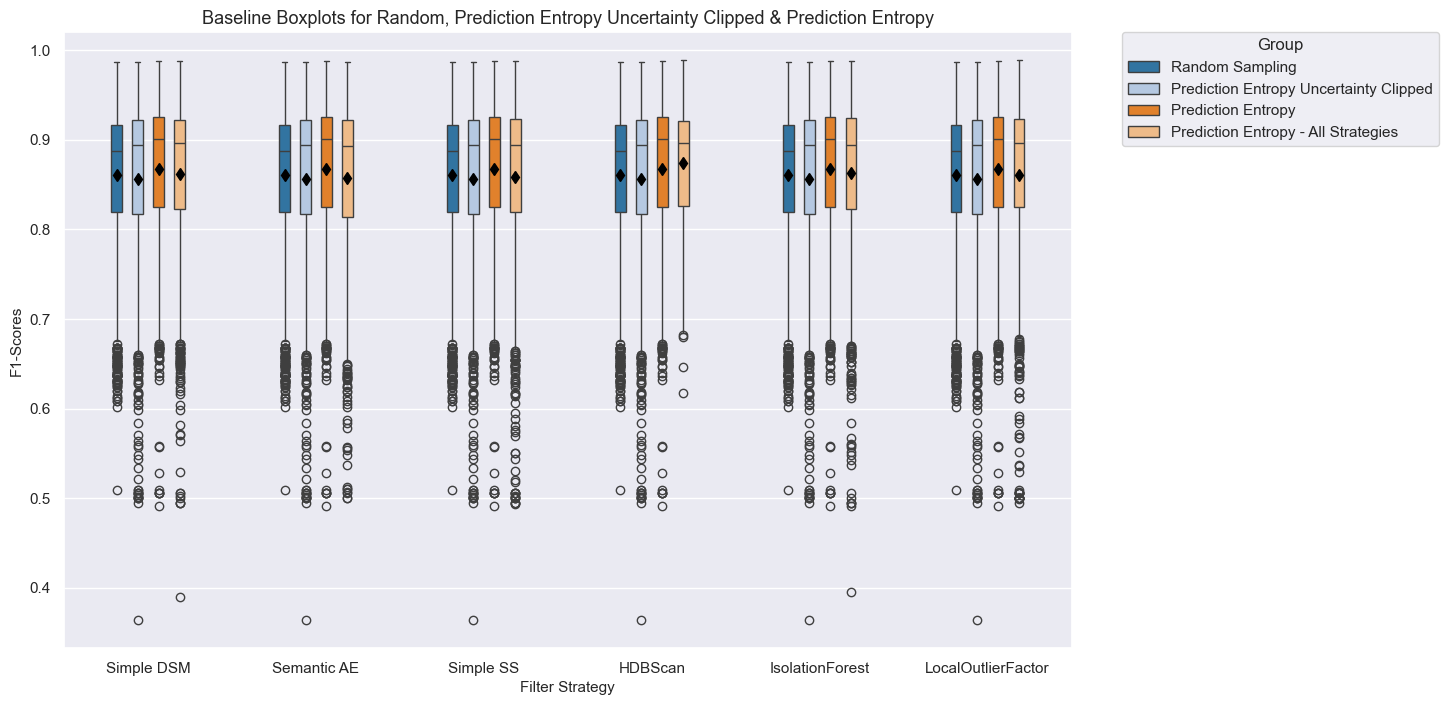

In [25]:
filter_names_clean = {
    "SimpleDSM": "Simple DSM",
    "SemanticAE": "Semantic AE",
    "SimpleSS": "Simple SS",
    "HDBScanFilter": "HDBScan",
    "IsolationForestFilter": "IsolationForest",
    "LocalOutlierFactorFilter": "LocalOutlierFactor",
}

def load_asset_data_baseline(ASSET_PATHS: Optional[Path] = Path("cache", "assets", COMET_WORKSPACE)) -> DefaultDict[str, List]:
    TASK_ASSET_MAP = defaultdict(list)
    for path in ASSET_PATHS.glob('**/*'):
        if path.name.endswith("f1s.npy"):
            task_name = path.parent.parent.name
            if task_name != COMET_WORKSPACE:
                data = np.load(path)
                if data.size == 0:
                    print(f"{path} is empty")
                TASK_ASSET_MAP[task_name].append(data)

    return TASK_ASSET_MAP


def collect_asset_paths(ASSET_PATHS: Optional[Path] = Path("cache", "assets", COMET_WORKSPACE)) -> DefaultDict[str, List]:
    TASK_ASSET_MAP = defaultdict(list)
    for path in ASSET_PATHS.glob('**/*'):
        if path.name.endswith("_f1s.npy"):
            task_name = path.parent.parent.name
            if task_name != COMET_WORKSPACE:
                TASK_ASSET_MAP[task_name].append(path)

    return TASK_ASSET_MAP

def load_asset_data(workspace_data: DefaultDict[str, List[Path]]) -> Dict[str, pd.DataFrame]:
    results = {}
    for task_name, assets in workspace_data.items():
        collected_dfs = defaultdict(list)

        for asset_path in assets:
            data = np.load(asset_path)
            if data.size == 0:
                print(f"{asset_path} is empty")

            filter_strategy_name = filter_names_clean[asset_path.name.replace("_f1s.npy", "")]
            collected_dfs[filter_strategy_name].append(data)


        df = pd.DataFrame.from_dict(collected_dfs, orient="index")
        df = df.transpose()
        results[task_name] = df
    return results

def transform_into_baseline(data):
    df = pd.DataFrame.from_dict(data, orient="columns")
    df_transformed = df.apply(pd.Series.explode).reset_index(drop=True)
    df_single_column = df_transformed.stack().reset_index(drop=True).to_frame(name="HDBScan")
    baseline = pd.concat([df_single_column.rename(columns={"HDBScan": col}) for col in filter_names_clean.values()], axis=1)
    return baseline

def transform_into_experimental_data(data):
    results = []
    for df in data.values():
        df_transformed = df.apply(pd.Series.explode).reset_index(drop=True)
        results.append(df_transformed)

    return pd.concat(results, axis=0, ignore_index=True)


def baseline() -> None:
    random_baseline_data = load_asset_data_baseline(ASSET_PATHS=Path("cache", "assets", "final-experiment-random-sampling-all-filters"))
    prediction_entropy_uncertainty_data = load_asset_data_baseline(ASSET_PATHS=Path("cache", "assets", "final-experiment-prediction-entropy-no-filters"))
    prediction_entropy_data = load_asset_data_baseline(ASSET_PATHS=Path("cache", "assets", "final-experiment-no-filters"))
    actual_experiments = load_asset_data(collect_asset_paths(ASSET_PATHS= Path("cache", "assets", "final-experiment-all-filters")))

    random_base = transform_into_baseline(random_baseline_data)
    uncertainty_base = transform_into_baseline(prediction_entropy_uncertainty_data)
    entropy_base = transform_into_baseline(prediction_entropy_data)
    experimental_data = transform_into_experimental_data(actual_experiments)

    random_base["Group"] = "Random Sampling"
    uncertainty_base["Group"] = "Prediction Entropy Uncertainty Clipped"
    entropy_base["Group"] = "Prediction Entropy"
    experimental_data["Group"] = "Prediction Entropy - All Strategies"

    dfs_combined = pd.concat([random_base, uncertainty_base, entropy_base, experimental_data])
    df_melted = dfs_combined.melt(id_vars="Group", var_name="Filter Strategy", value_name="F1-Scores")

    sns.set_theme()
    custom_palette = sns.color_palette("tab20")

    plt.figure(figsize=(13, 8))
    sns.boxplot(data=df_melted, x="Filter Strategy", y="F1-Scores", hue="Group", palette=custom_palette, showmeans=True, width=0.5, gap=0.5, meanprops={"marker":"d","markerfacecolor":"black", "markeredgecolor":"black"})

    plt.title("Baseline Boxplots for Random, Prediction Entropy Uncertainty Clipped & Prediction Entropy", fontsize=13)
    plt.xlabel("Filter Strategy", fontsize=11)
    plt.ylabel("F1-Scores", fontsize=11)

    plt.legend(
    title="Group",
    bbox_to_anchor=(1.05, 1),  # Place it outside the plot on the right
    loc="upper left",          # Anchor it to the upper left of the bbox
    borderaxespad=0            # Add padding between the axes and legend
    )

    plt.show()


def end_performance_comparison() -> None:
    workspace_data = collect_asset_paths()
    f1_scores_map = load_asset_data(workspace_data=workspace_data)

    dfs = []
    for task_name, df in f1_scores_map.items():
        collected_assets = {}
        for col in df.columns:
            values = df[col].values
            df_summarised = np.concatenate([array_with_values if array_with_values is not None else np.array([]) for array_with_values in values])
            collected_assets[col] = df_summarised


        asset_df = pd.DataFrame(data=[collected_assets], index=[task_name])
        dfs.append(asset_df)

    merged_df = pd.concat(dfs)

    summary = pd.DataFrame({
        col: [np.concatenate(merged_df[col].values)]  # Concatenate all arrays in each column
        for col in merged_df.columns
    })

    sns.set_theme()

    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=summary,
        showmeans=True
        )


    plt.show()

# end_performance_comparison()
baseline()

### Lineplot for Percentiles Experiment

In [11]:
def load_asset_data_baseline(ASSET_PATHS: Optional[Path] = Path("cache", "assets", COMET_WORKSPACE)) -> DefaultDict[str, List]:
    TASK_ASSET_MAP = defaultdict(list)
    for path in ASSET_PATHS.glob('**/*'):
        if path.name.endswith("f1s.npy"):
            task_name = path.parent.parent.name
            if task_name != COMET_WORKSPACE:
                data = np.load(path)
                if data.size == 0:
                    print(f"{path} is empty")
                TASK_ASSET_MAP[task_name].append(data)

    return TASK_ASSET_MAP


def collect_asset_paths(ASSET_PATHS: Optional[Path] = Path("cache", "assets", COMET_WORKSPACE)) -> DefaultDict[str, List]:
    TASK_ASSET_MAP = defaultdict(list)
    for path in ASSET_PATHS.glob('**/*'):
        if path.name.endswith("_f1s.npy"):
            task_name = path.parent.parent.name
            if task_name != COMET_WORKSPACE:
                TASK_ASSET_MAP[task_name].append(path)

    return TASK_ASSET_MAP

def load_asset_data(workspace_data: DefaultDict[str, List[Path]]) -> Dict[str, pd.DataFrame]:
    results = {}
    for task_name, assets in workspace_data.items():
        collected_dfs = defaultdict(list)

        for asset_path in assets:
            data = np.load(asset_path)
            if data.size == 0:
                print(f"{asset_path} is empty")

            filter_strategy_name = filter_names_clean[asset_path.name.replace("_f1s.npy", "")]
            collected_dfs[filter_strategy_name].append(data)


        df = pd.DataFrame.from_dict(collected_dfs, orient="index")
        df = df.transpose()
        results[task_name] = df
    return results

def transform_into_baseline(data, workspace_name):
    df = pd.DataFrame.from_dict(data, orient="columns")
    df_transformed = df.apply(pd.Series.explode).reset_index(drop=True)
    df_mean = df_transformed.mean(axis=0)
    result_df = pd.DataFrame({workspace_name : df_mean.values}, index=[df_mean.index])
    return result_df

def prepare_percentiles_data():
    workspaces = ["final-experiment-85-percentile","final-experiment-90-percentile", "final-experiment-95-percentile", "final-experiment-99-percentile"]
    results = [load_asset_data_baseline(ASSET_PATHS=Path("cache", "assets", workspace)) for workspace in workspaces]
    x = pd.concat([transform_into_baseline(data, workspaces[index]) for index, data in enumerate(results, start=0)], axis=1)
    return x

prepare_percentiles_data()

,final-experiment-85-percentile,final-experiment-90-percentile,final-experiment-95-percentile,final-experiment-99-percentile
xFNC1,0.903373,0.902581,0.901691,0.903888
xAG News,0.887682,0.884149,0.885172,0.88423
xSST2,0.870505,0.866445,0.871388,0.869071
xTREC,0.65424,0.65216,0.64988,0.6532
xWiki Talk,0.917364,0.917832,0.917442,0.918031
xDBPedia,0.981789,0.981792,0.981809,0.981931
xRotten Tomatoes,0.642101,0.627083,0.635938,0.637627
xIMDB,0.919028,0.91793,0.917684,0.917108
xQNLI,0.794228,0.788953,0.785444,0.787207
